In [3]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

In [4]:
#From blog - https://www.drivendata.co/blog/dengue-benchmark/

def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']
    df = df[features]
    
    # fill missing values = impute
    
    #forward fill
    #df.fillna(method='ffill', inplace=True)

    #simple impute with median
    #missing_values should be set to np.nan, since pd.NA will be converted to np.nan
    #simple_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    #data_with_imputed_values = simple_imputer.fit_transform(df)
    
    #KNN imputer = K-nearest neighbor
    #Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set.
    #knn_imputer = KNNImputer(n_neighbors=2)
    #data_with_imputed_values = knn_imputer.fit_transform(df)
        
    #A more sophisticated approach is to use the IterativeImputer class, 
    #which models each feature with missing values as a function of other features, 
    #and uses that estimate for imputation. 
    #It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y 
    #and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. 
    #Then, the regressor is used to predict the missing values of y. 
    #This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. 
    #The results of the final imputation round are returned.
    
    #Note This estimator is still experimental for now: 
    #default parameters or details of behaviour might change without any deprecation cycle
    imp_imputer = IterativeImputer(max_iter=10, random_state=0)  
    imp_imputer.fit(df)
    IterativeImputer(random_state=0)
    data_with_imputed_values = imp_imputer.transform(df)
    
    #Output of sklearn imputers in a numpy array. Convert it to pandas dataframe
    idf = pd.DataFrame(data_with_imputed_values)
    idf.columns=df.columns
    idf.index=df.index
    
    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        #df = df.join(labels)
        idf = idf.join(labels)
    
    # separate san juan and iquitos
    #sj = df.loc['sj']
    #iq = df.loc['iq']
    sj = idf.loc['sj']
    iq = idf.loc['iq']    
    
    return sj, iq

## NOTE: Various imputation methods have no impact on RMSE score for this data. No need to spend more time exploring imputation techniques for now.

In [5]:
sj_train, iq_train = preprocess_data(r"C:\Users\FunTime\Desktop\DengAI_Competetion\dengue_features_train.csv",
                                    labels_path="C:\\Users\\FunTime\\Desktop\\DengAI_Competetion\\dengue_labels_train.csv")

In [6]:
sj_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,16.553652,295.110396,27.007633,22.597454,34.180556
std,1.555984,1.564936,1.410992,1.501962,51.381372
min,11.715714,289.642857,22.842857,17.800000,0.000000
25%,15.248214,293.853214,25.842857,21.700000,9.000000
50%,16.832143,295.447143,27.214286,22.800000,19.000000
75%,17.854286,296.415714,28.175000,23.900000,37.000000
max,19.440000,297.795714,30.071429,25.600000,461.000000


In [7]:
iq_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,520.000000,520.000000,520.000000,520.000000,520.000000
mean,17.093420,295.491085,27.487072,21.212699,7.565385
std,1.440511,1.411922,0.947699,1.257357,10.765478
min,12.111429,290.088571,21.400000,14.700000,0.000000
25%,16.121429,294.596429,26.993750,20.600000,1.000000
50%,17.420714,295.831429,27.587500,21.400000,5.000000
75%,18.176786,296.544643,28.100000,22.000000,9.000000
max,20.461429,298.450000,30.800000,24.200000,116.000000


In [8]:
#Split train data to train & test
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [9]:
import statsmodels.api as sm
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf


def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  21.948529411764707
best alpha =  1e-08
best score =  6.475


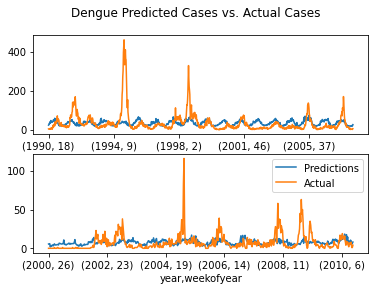

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()


In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sj_mse = mean_squared_error(sj_train.total_cases, sj_best_model.fittedvalues)
sj_rmse = sqrt(sj_mse)
print(sj_rmse)

iq_mse = mean_squared_error(iq_train.total_cases, iq_best_model.fittedvalues)
iq_rmse = sqrt(iq_mse)
print(iq_rmse)

50.10567334528417
10.432122558102279


In [12]:
from sklearn.metrics import mean_absolute_error
#print("Mean Absolute Error:")
print(mean_absolute_error(sj_train.total_cases, sj_best_model.fittedvalues))
print(mean_absolute_error(iq_train.total_cases, iq_best_model.fittedvalues))

27.079139489078287
6.361434237063585


In [14]:
sj_test, iq_test = preprocess_data(r"C:\Users\FunTime\Desktop\DengAI_Competetion\dengue_features_test.csv")

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv(r"C:\Users\FunTime\Desktop\DengAI_Competetion\submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv(r"C:\Users\FunTime\Desktop\DengAI_Competetion\benchmark1.csv")